<a href="https://colab.research.google.com/github/shinome551/MachineLearningSeminar/blob/main/Co_teaching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import torchvision.transforms as T
from torchvision.datasets import MNIST
device = torch.device('cuda:0')

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 8,4.5
sns.set()

# MNIST dataset

In [8]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(0.5, 0.5)
])
trainset = MNIST(root='./data', train=True, download=True, transform=transform)
testset = MNIST(root='./data', train=False, download=True, transform=transform)

# Label Noise

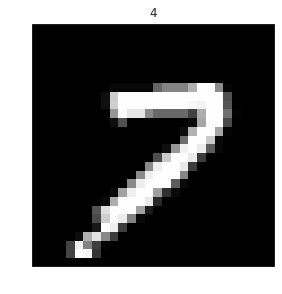

In [9]:
idx = 59915 # 10994
plt.imshow(trainset.data[idx], cmap='gray')
plt.title(trainset.targets[idx].item())

plt.grid(False)
plt.xticks(color='w')
plt.yticks(color='w')
plt.show()

In [10]:
## label transition matrix
noise_type = "symmetry"
noise_rate = 0.2
num_classes = 10
if noise_type == "symmetry":
    Q = torch.empty(size=(num_classes, num_classes))
    Q.fill_(noise_rate / (num_classes - 1))
    Q += (1.0 - noise_rate - Q[0,0]) * torch.eye(10)
else:
    pass
print(Q[0])

tensor([0.8000, 0.0222, 0.0222, 0.0222, 0.0222, 0.0222, 0.0222, 0.0222, 0.0222,
        0.0222])


In [11]:
torch.multinomial(torch.tensor([1.,2.,8.]), 1)

tensor([2])

In [12]:
noised_trainset = MNIST(root='./data', train=True, download=True, transform=transform)
noised_trainset.targets = torch.multinomial(Q[trainset.targets], 1)

In [13]:
class_id, num_per_class = torch.unique(trainset.targets, return_counts=True)
print(f"train data per class:{dict(zip(class_id.tolist(), num_per_class.tolist()))}")
class_id, num_per_class = torch.unique(testset.targets, return_counts=True)
print(f"test data per class:{dict(zip(class_id.tolist(), num_per_class.tolist()))}")
class_id, num_per_class = torch.unique(noised_trainset.targets, return_counts=True)
print(f"noised train data per class:{dict(zip(class_id.tolist(), num_per_class.tolist()))}")

train data per class:{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
test data per class:{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
noised train data per class:{0: 5910, 1: 6582, 2: 6014, 3: 6036, 4: 5895, 5: 5529, 6: 5968, 7: 6179, 8: 5871, 9: 6016}


In [14]:
batchsize = 128
trainloader = DataLoader(noised_trainset, batch_size=batchsize, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=False, pin_memory=True, num_workers=2)

# Standard

In [15]:
def train(model, optimizer, trainloader, device):
    model.train()
    trainloss = 0
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        trainloss += loss.item()

    trainloss = trainloss / len(trainloader)
    return trainloss


def test(model, testloader, device):
    model.eval()
    correct = 0
    with torch.no_grad():
        for (inputs, labels) in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            pred = torch.argmax(outputs, 1)
            correct += (pred == labels).sum().item()
    acc = 100 * correct / len(testloader.dataset)
    return acc

In [16]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=
                     lambda epoch: (200 - epoch) / 120 if epoch > 80 else 1.0)

In [17]:
num_epoch = 200
start = time.time()
trainloss_list = []
accuracy_list = []
for epoch in range(num_epoch):
    trainloss = train(model, optimizer, trainloader, device)
    accuracy = test(model, testloader, device)
    print(f"epoch:{epoch+1}, trainloss:{trainloss:.3f}, accuracy:{accuracy:.1f}%")
    trainloss_list.append(trainloss)
    accuracy_list.append(accuracy)
    scheduler.step()

time_per_epochs = (time.time() - start) / num_epoch
print(f"time per epochs:{time_per_epochs:.3f}s, top acc:{max(accuracy_list):.1f}%")

epoch:1, trainloss:1.262, accuracy:91.9%
epoch:2, trainloss:1.137, accuracy:94.0%
epoch:3, trainloss:1.102, accuracy:94.3%
epoch:4, trainloss:1.078, accuracy:95.7%
epoch:5, trainloss:1.064, accuracy:95.6%
epoch:6, trainloss:1.052, accuracy:95.6%
epoch:7, trainloss:1.042, accuracy:96.3%
epoch:8, trainloss:1.032, accuracy:95.9%
epoch:9, trainloss:1.026, accuracy:96.0%
epoch:10, trainloss:1.019, accuracy:96.6%
epoch:11, trainloss:1.010, accuracy:96.7%
epoch:12, trainloss:1.003, accuracy:96.3%
epoch:13, trainloss:0.998, accuracy:96.6%
epoch:14, trainloss:0.994, accuracy:95.9%
epoch:15, trainloss:0.989, accuracy:96.3%
epoch:16, trainloss:0.981, accuracy:96.1%
epoch:17, trainloss:0.976, accuracy:96.7%
epoch:18, trainloss:0.973, accuracy:96.5%
epoch:19, trainloss:0.964, accuracy:96.4%
epoch:20, trainloss:0.960, accuracy:96.3%
epoch:21, trainloss:0.956, accuracy:95.9%
epoch:22, trainloss:0.951, accuracy:96.4%
epoch:23, trainloss:0.945, accuracy:96.0%
epoch:24, trainloss:0.940, accuracy:96.2%
e

# Co-teaching

In [18]:
def co_teaching(model_f, model_g, lamd, optimizer, trainloader, device):
    v_batch_size = int(lamd * trainloader.batch_size) 
    model_f.train()
    model_g.train()
    trainloss_f = 0
    trainloss_g = 0
    for (inputs, labels) in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        ## model_f's forward
        outputs_f = model_f(inputs)
        loss_f = F.cross_entropy(outputs_f, labels, reduction='none')
        idx = torch.argsort(loss_f.data)[v_batch_size-1]
        weight_f = (loss_f.data <= loss_f.data[idx]).to(torch.float32) / v_batch_size
        ## model_g's forward
        outputs_g = model_g(inputs)
        loss_g = F.cross_entropy(outputs_g, labels, reduction='none')
        idx = torch.argsort(loss_g.data)[v_batch_size-1]
        weight_g = (loss_g.data <= loss_g.data[idx]).to(torch.float32) / v_batch_size
        ## backward
        loss_f.backward(weight_g)
        loss_g.backward(weight_f)
        optimizer.step()
        trainloss_f += (loss_f.data * weight_g).mean().item()
        trainloss_g += (loss_g.data * weight_f).mean().item()

    trainloss_f = trainloss_f / len(trainloader)
    trainloss_g = trainloss_g / len(trainloader)
    return trainloss_f, trainloss_g

In [19]:
model_f = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
model_f.to(device)

model_g = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
)
model_g.to(device)

lr = 0.001
optimizer = Adam(list(model_f.parameters()) + list(model_g.parameters()), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=
                     lambda epoch: (200 - epoch) / 120 if epoch > 80 else 1.0)

In [20]:
num_epoch = 200
E_k = 10
start = time.time()
trainloss_list_coteaching = []
accuracy_list_coteaching = []
for epoch in range(num_epoch):
    lamd = 1.0 - min(noise_rate * epoch / E_k,  noise_rate)
    trainloss = min(co_teaching(model_f, model_g, lamd, optimizer, trainloader, device))
    accuracy = max(test(model_f, testloader, device), test(model_g, testloader, device))
    print(f"epoch:{epoch+1}, trainloss:{trainloss:.3f}, accuracy:{accuracy:.1f}%")
    trainloss_list_coteaching.append(trainloss)
    accuracy_list_coteaching.append(accuracy)
    scheduler.step()

time_per_epochs = (time.time() - start) / num_epoch
print(f"time per epochs:{time_per_epochs:.3f}s, top acc:{max(accuracy_list_coteaching):.1f}%")

epoch:1, trainloss:0.010, accuracy:92.1%
epoch:2, trainloss:0.008, accuracy:94.5%
epoch:3, trainloss:0.007, accuracy:94.6%
epoch:4, trainloss:0.006, accuracy:95.8%
epoch:5, trainloss:0.006, accuracy:96.2%
epoch:6, trainloss:0.005, accuracy:96.0%
epoch:7, trainloss:0.004, accuracy:96.4%
epoch:8, trainloss:0.003, accuracy:96.7%
epoch:9, trainloss:0.002, accuracy:95.8%
epoch:10, trainloss:0.001, accuracy:96.6%
epoch:11, trainloss:0.001, accuracy:96.7%
epoch:12, trainloss:0.001, accuracy:96.4%
epoch:13, trainloss:0.001, accuracy:96.0%
epoch:14, trainloss:0.001, accuracy:96.7%
epoch:15, trainloss:0.001, accuracy:96.9%
epoch:16, trainloss:0.001, accuracy:96.9%
epoch:17, trainloss:0.001, accuracy:96.4%
epoch:18, trainloss:0.001, accuracy:96.9%
epoch:19, trainloss:0.001, accuracy:97.1%
epoch:20, trainloss:0.001, accuracy:96.9%
epoch:21, trainloss:0.001, accuracy:97.0%
epoch:22, trainloss:0.001, accuracy:96.4%
epoch:23, trainloss:0.001, accuracy:96.5%
epoch:24, trainloss:0.001, accuracy:97.3%
e

# Plot

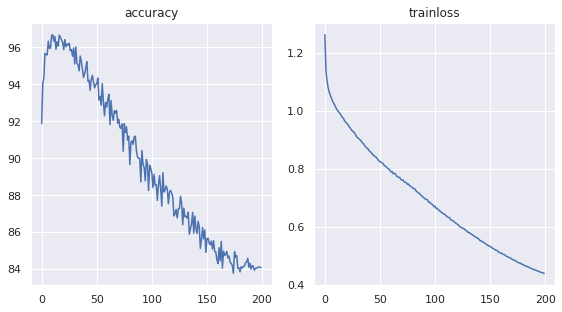

In [21]:
fig, ax = plt.subplots(1,2)
ax[0].plot(accuracy_list)
ax[1].plot(trainloss_list)
ax[0].set_title("accuracy")
ax[1].set_title("trainloss")
fig.tight_layout()
plt.show()

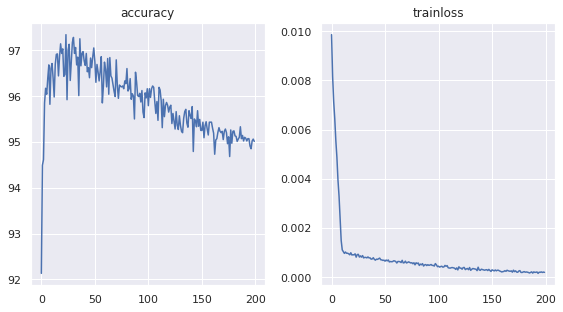

In [22]:
fig, ax = plt.subplots(1,2)
ax[0].plot(accuracy_list_coteaching)
ax[1].plot(trainloss_list_coteaching)
ax[0].set_title("accuracy")
ax[1].set_title("trainloss")
fig.tight_layout()
plt.show()

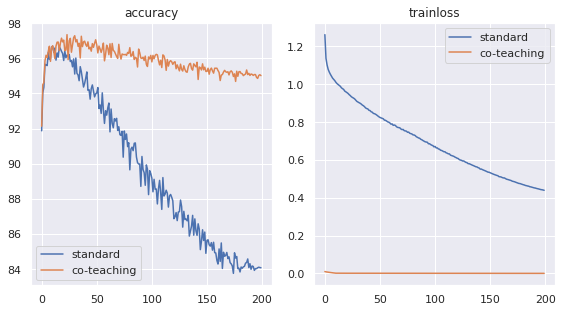

In [23]:
fig, ax = plt.subplots(1,2)
ax[0].plot(accuracy_list, label="standard")
ax[1].plot(trainloss_list, label="standard")
ax[0].plot(accuracy_list_coteaching, label="co-teaching")
ax[1].plot(trainloss_list_coteaching, label="co-teaching")
ax[0].set_title("accuracy")
ax[1].set_title("trainloss")
fig.tight_layout()
ax[0].legend()
ax[1].legend()
plt.show()